# Reads the Synthetic Data and Does the Balanced Extraction

In [ ]:
import JWS_SWOT_toolbox as swot
import pickle 
from datetime import datetime, timedelta
import numpy as np
import xarray as xr
from scipy.linalg import block_diag
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import cho_solve
import cmocean

%load_ext autoreload
%autoreload 2

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [1]:
### Read in our Pickles
with open("./pickles/karin_NA_tmean.pkl", "rb") as f:
    karin_NA = pickle.load(f)

with open("./pickles/nadir_NA_tmean.pkl", "rb") as f:
    nadir_NA = pickle.load(f)

with open("./pickles/karin.pkl", "rb") as f:
    karin = pickle.load(f)

with open("./pickles/nadir.pkl", "rb") as f:
    nadir = pickle.load(f)

NameError: name 'pickle' is not defined

### 1. Fit models to synthetic SWOT spectra


---- KaRIn spectrum parameters ----
Amp. balanced   :   1.2673e+05 ± 1.74e+03
lambda balanced :   2.7718e+02 ± 2.49e+00
slope balanced  :   4.7266e+00 ± 5.77e-02
Amp. noise      :   5.9857e+01 ± 8.07e+01
lambda noise    :   1.0000e+02 ± 7.33e+01
slope noise     :   1.9434e+00 ± 3.46e-02

---- Nadir spectrum parameters ----
Fitted Nadir noise floor N = 332.9374185452699 ± 9.35e+00


(<Figure size 960x480 with 2 Axes>,
 array([<Axes: title={'center': 'KaRIn'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>,
        <Axes: title={'center': 'Nadir'}, xlabel='wavenumber (cpkm)', ylabel='PSD (cm$^2$ / cpkm)'>],
       dtype=object))

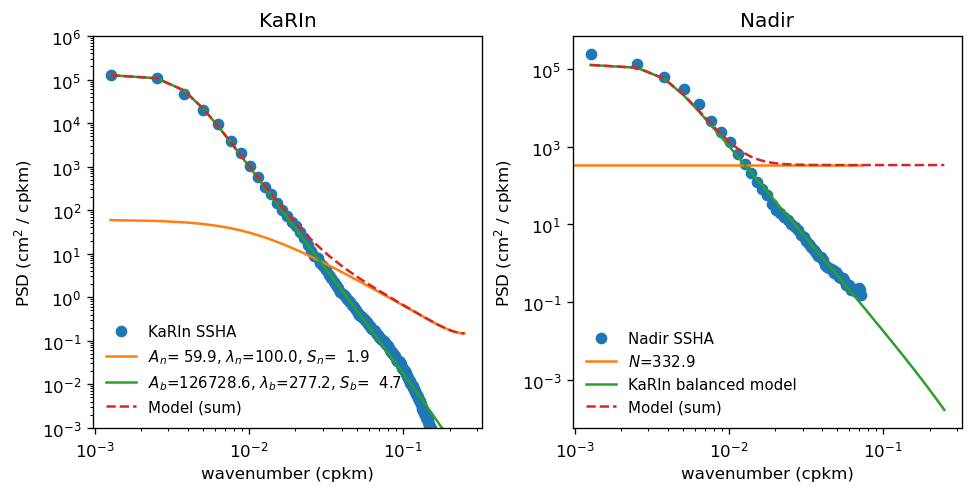

In [3]:
# KARIN
ntime = karin_NA.ssha.shape[0]
k_karin_NA = (karin_NA.wavenumbers_cpkm[int(karin_NA.track_length/2):]) # this is in units [1/m] 
karin_spec_sample_mean_NA = karin_NA.spec_alongtrack_av[int(karin_NA.track_length/2):]

# noisy KaRIn spectrum
kt_NA_coords    = [np.arange(ntime), karin_NA.y_coord_km, karin_NA.x_coord_km]
ssh_noisy_xr = xr.DataArray(karin_NA.ssh_noisy * 100, coords = kt_NA_coords, dims = ['sample', 'line', 'pixel'])
spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin_NA.window, 'line', ['sample', 'pixel'])

# noisy Nadir Spectrum
nt_NA_coords    = [np.arange(ntime), nadir_NA.y_coord_km]
nad_noisy_xr = xr.DataArray(nadir_NA.ssh_noisy * 100, coords = nt_NA_coords, dims = ['sample', 'nadir_line'])
spec_nad_noisy = swot.mean_power_spectrum(nad_noisy_xr, nadir_NA.window, 'nadir_line', ['sample'])


# KaRIn model fit
poptcwg_karin_NA, pcovcwg_karin_NA = swot.fit_spectrum(karin_NA, spec_ssh_noisy, swot.karin_model)

# Nadir model fit
poptcwg_nadir_NA, covcwg_nadir_NA = swot.fit_nadir_spectrum(nadir_NA, spec_nad_noisy, poptcwg_karin_NA)

# Plot the fits
swot.plot_spectral_fits(karin_NA, nadir_NA, poptcwg_karin_NA, poptcwg_nadir_NA)

In [4]:
nx, ny = 2 * karin.swath_width, karin.track_length
nn = nadir.track_length
dx, dy, dn = karin.dx_km, karin.dy_km, nadir.dy_km

index = 40 # time index to estimate on 

# Create covariance functions
c = swot.balanced_covariance_func(poptcwg_karin_NA)
nk = swot.noise_covariance_func(poptcwg_karin_NA)

N_n = poptcwg_nadir_NA[0] # Nadir noise
sigma_n = np.sqrt(N_n / (2 * dn))

# Build masks
mask_k = ~np.isnan(karin_NA.ssh_noisy[index])
mask_n = ~np.isnan(nadir_NA.ssh_noisy[index])

# Obs values from our measurement--- Since our spectra are fitted in cm, convert h to cm
h_obs = np.concatenate((
    100*karin_NA.ssh_noisy[index][mask_k].flatten(order="C"),
    100*nadir_NA.ssh_noisy[index][mask_n]
))

# Build covariance matrix grids in [km]
xkk = karin_NA.x_grid[mask_k].flatten(order="C")*1e-3
ykk = karin_NA.y_grid[mask_k].flatten(order="C")*1e-3
xnn = nadir_NA.x_grid.ravel()[mask_n]*1e-3
ynn = nadir_NA.y_grid.ravel()[mask_n]*1e-3

xobs = np.concatenate((xkk, xnn))
yobs = np.concatenate((ykk, ynn))

# Build covariance matrix from covariance functions
C_obs = swot.build_covariance_matrix(c, xobs, yobs)

# Build noise matrices
Nk_obs = nk(np.hypot(
    xobs[:len(xkk), None] - xobs[:len(xkk)],
    yobs[:len(xkk), None] - yobs[:len(xkk)]
))

Nn_obs = sigma_n**2 * np.eye(len(xnn))
N_obs = block_diag(Nk_obs, Nn_obs)

#build cholesky factor
cho_tuple = la.cho_factor(C_obs + N_obs, lower=True)

# target grids 
xt, yt, nxt, nyt, _, _ = swot.make_target_grid(karin_NA, unit = 'km', extend = False) # we've flipped xt and yt so the grid align

# compute the covariance first 
R = c(np.hypot(xt[:, None] - xobs, yt[:, None] - yobs))

# Estimate signal
ht_NA_sim = swot.estimate_signal_on_target_cho_solve(R, cho_tuple, h_obs) # faster function

Δk (spacing): 0.000100 cpkm
k_max (maximum wavenumber): 250.000000 cpkm
Variance from spectrum:   492.627813
Variance from covariance: 492.627813
Δk (spacing): 0.000100 cpkm
k_max (maximum wavenumber): 0.250000 cpkm
Variance from spectrum:   0.938125
Variance from covariance: 0.938125
Calculating covariance matrices...
Signal estimation time: 1.5365 seconds


In [ ]:
# Posterior covariance, this takes some time 
C_target = swot.build_covariance_matrix(c, xt, yt) # Covariance of my target matrix

#  P = C_target - R(C_obs + N_obs)⁻¹ @ R.T
print("Solving linear part")
#term = solve(C_obs + N_obs, R.T, assume_a='pos') # assume positive definite 
term = la.cho_solve(cho_tuple, R.T)

# 2. Posterior
print("posterior covariance matrix")
P = C_target - R @ term

# 3. Diagonal is posterior variance
posterior_variance = np.diag(P)

# 4. Reshape to target grid
posterior_variance_field = posterior_variance.reshape(nyt, nxt)
print("Done.")

Calculating covariance matrices...


In [ ]:
# === 2. Posterior covariance (Eq. 10) ===
print("Cholesky decomposition of posterior covariance P...")
L = np.linalg.cholesky(P)

# --- Also compute covariance of the posterior mean (Eq. 9 second term) ---
print("Computing covariance of posterior mean (C_mean = R(C+N)^-1 R^T)...")
C_mean = R @ term  # equivalent to C_target - P

print("done")

In [ ]:
# === 1. Spectrum of the mean estimate from balanced extraction ===
ht_NA_2d = ht_NA_sim.reshape(nyt, nxt).T
ht_NA_coords = { 
    'pixel': np.arange(0.5, np.shape(ht_NA_2d)[0], 1.0) * karin.dy_km, 
    'line': np.arange(0.5, np.shape(ht_NA_2d)[1], 1.0) * karin.dx_km
}
ht_map_xr = xr.DataArray(ht_NA_2d, coords=ht_NA_coords, dims=['pixel', 'line'])
window_line = xr.DataArray(swot.sin2_window_func(np.shape(ht_NA_2d)[1]),
                           dims=['line'], coords={'line': ht_map_xr['line']})
spec_ht_map = swot.mean_power_spectrum(ht_map_xr, window_line, 'line', ['pixel'])
bal_k = spec_ht_map.freq_line[int(karin.track_length/2):]
spec_ht_map = 2 * spec_ht_map[int(karin.track_length/2):]

# Cholesky for posterior-mean covariance
eps = 1e-10 * np.trace(C_mean) / C_mean.shape[0]
L_mean = np.linalg.cholesky(C_mean + eps * np.eye(C_mean.shape[0]))

nreal = 20
half_idx = int(karin.track_length // 2)
rng = np.random.default_rng(seed=42)

all_specs = []               # posterior spectra
all_specs_uncertainty = []   # uncertainty (P) spectra
all_specs_mean_cov = []      # covariance of posterior mean (C_mean) spectra

for i in range(nreal):
    # === Posterior covariance sampling (uncertainty realizations) ===
    z = rng.standard_normal(len(P))
    eps = L @ z
    sample = ht_NA_sim + eps  # posterior sample = mean + uncertainty

    field2d = sample.reshape((nyt, nxt), order='C')
    da = xr.DataArray(
        field2d[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )

    spec_xr = swot.mean_power_spectrum(da, karin.window, 'line', ['sample', 'pixel'])
    spec_vals = 2 * spec_xr[int(karin.track_length/2):]
    spec_1d = spec_vals[half_idx:] if spec_vals.size == karin.wavenumbers_cpkm.size else spec_vals
    all_specs.append(spec_1d)

    # === Posterior uncertainty spectrum (from eps field) ===
    field2d_unc = eps.reshape((nyt, nxt), order='C')
    da_unc = xr.DataArray(
        field2d_unc[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr_unc = swot.mean_power_spectrum(da_unc, karin.window, 'line', ['sample', 'pixel'])
    spec_vals_unc = 2 * spec_xr_unc[int(karin.track_length/2):]
    spec_1d_unc = spec_vals_unc[half_idx:] if spec_vals_unc.size == karin.wavenumbers_cpkm.size else spec_vals_unc
    all_specs_uncertainty.append(spec_1d_unc)

    # === Covariance of posterior mean sampling ===
    zm = rng.standard_normal(len(C_mean))
    eps_mean = L_mean @ zm
    field2d_mean = eps_mean.reshape((nyt, nxt), order='C')
    da_mean = xr.DataArray(
        field2d_mean[None, :, :],
        coords=[[i], karin.y_coord_km, karin.x_coord_km],
        dims=['sample', 'line', 'pixel']
    )
    spec_xr_mean = swot.mean_power_spectrum(da_mean, karin.window, 'line', ['sample', 'pixel'])
    spec_vals_mean = 2 * spec_xr_mean[int(karin.track_length/2):]
    spec_1d_mean = spec_vals_mean[half_idx:] if spec_vals_mean.size == karin.wavenumbers_cpkm.size else spec_vals_mean
    all_specs_mean_cov.append(spec_1d_mean)

# === 3. Aggregate stats ===
all_spectra = np.array(all_specs)
spec_mean = np.nanmean(all_spectra, axis=0)
spec_std = np.nanstd(all_spectra, axis=0)
spec_median = np.nanmedian(all_spectra, axis=0)
spec_mean_uncertainty = np.nanmean(np.array(all_specs_uncertainty), axis=0)
spec_mean_of_mean = np.nanmean(np.array(all_specs_mean_cov), axis=0)

print("Spectral diagnostics computed:")
print("  - spec_mean: posterior mean spectrum")
print("  - spec_mean_uncertainty: posterior uncertainty spectrum")
print("  - spec_mean_of_mean: covariance of posterior mean spectrum")

In [ ]:
def plot_spectrum_comparison(karin_obj, swot_obj, poptcwg_karin_params, ht_map_2d):
    
    # Extract KaRIn wavenumbers and sample mean spectrum
    k_karin = karin_obj.wavenumbers_cpkm[int(karin_obj.track_length/2):]
    karin_spec_sample_mean = karin_obj.spec_alongtrack_av[int(karin_obj.track_length/2):]

    # Ensure consistent slicing for model inputs (skipping the first wavenumber)
    k_karin_sliced = k_karin[1:]

    # Put the wavenumbers through the models to get the functional form
    spbalanced = swot_obj.balanced_model_tapered(k_karin_sliced, *poptcwg_karin_params[0:3])
    spunbalanced = swot_obj.unbalanced_model_tapered(k_karin_sliced, *poptcwg_karin_params[3:7])

    nx_dim = ht_map_2d.shape[1] # Along-track dimension
    ny_dim = ht_map_2d.shape[0] # Across-track dimension 
    ht_map_coords = {
        'pixel': np.arange(0, ny_dim) * karin_obj.dy_km, # Across-track coordinate
        'line': np.arange(0, nx_dim) * karin_obj.dx_km   # Along-track coordinate
    }
    ht_map_xr = xr.DataArray((ht_map_2d - np.mean(ht_map_2d)), coords=ht_map_coords, dims=['pixel', 'line'])
    spec_ht_map_2s = swot_obj.mean_power_spectrum(ht_map_xr, karin_obj.window, 'line', ['pixel'])
    spec_ht_map = spec_ht_map_2s[int(karin_obj.track_length/2):][1:]

    # KaRIn instantaneous spectrum
    spec_k_ins = karin_NA.spec_alongtrack_ins[index][int(karin_obj.track_length/2):][1:]

    # noisy KaRIn spectrum
    kt_NA_coords    = [np.arange(ntime), karin_NA.y_coord_km, karin_NA.x_coord_km]
    
    ssh_noisy_xr = xr.DataArray(karin_NA.ssh_noisy[index] * 100, coords = ht_map_coords, dims = ['line', 'pixel'])
    spec_ssh_noisy = swot.mean_power_spectrum(ssh_noisy_xr, karin_NA.window, 'line', ['pixel'])
    spec_synth = spec_ssh_noisy[int(karin_obj.track_length/2):][1:]


    # --- Plotting ---
    fig, axs = plt.subplots(1, 1, figsize=(5.3, 5.), dpi=150, constrained_layout=True)
    k_km = k_karin_sliced 
    
    # axs.loglog(
    #     k_km, karin_spec_sample_mean[1:], 'o', color='blue',
    #     label='KaRIn SSHA Time Av.'
    # )

    axs.loglog(
        k_km, spec_k_ins, color='k',
        label='NA Sim.'
    )

    axs.loglog(
        k_km, spec_synth, color='tab:orange',
        label='Synthetic KaRIn'
    )
    
    # Unbalanced (tab:orange)
    # axs.loglog(
    #     k_km, spunbalanced , color='tab:orange',
    #     label=r'Noise model'
    # )
    
    # Balanced (tab:green)
    # axs.loglog(
    #     k_km, spbalanced , color='tab:green',
    #     label=r'Balanced Model'
    # )
    
    # Extracted balanced flow (tab:red, solid)
    axs.loglog(
        k_km, spec_ht_map , color='tab:purple', lw=2,
        label='Extracted SSH'
    )

    axs.loglog(k_km[:], 0.5*spec_mean_uncertainty[1:], color='tab:red', label = 'Posterior uncertainty')
    axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:],color='tab:green', label = 'Posterior mean covariance')
    #axs.loglog(k_km[:], 0.5*spec_mean_of_mean[1:] + 0.5*spec_mean_uncertainty[1:],color='tab:purple', label = 'Sum')

    separation_scale_km = 31.5
    separation_wavenumber = 1/separation_scale_km 
    axs.axvline(x=separation_wavenumber, color='grey', linestyle='-', lw=1.0, alpha = 0.5)
    text_label = f'{separation_scale_km:.1f} km'
    ymin, ymax = axs.get_ylim()
    y_pos = 1e4
    axs.text(separation_wavenumber * 1.1, y_pos, text_label,
            rotation=90,          # Rotate text to be vertical
            color='dimgrey',      # A slightly darker grey for readability
            fontsize=10,
            verticalalignment='center',
            horizontalalignment='left')
    
    # Axis labels and limits
    axs.set_xlabel('Wavenumber (cpkm)', fontsize=13)
    axs.set_ylabel('PSD (cm$^2$ / cpkm)', fontsize=13)
    axs.set_xlim(1e-3, 3e-1)
    axs.set_ylim(1e-5, 1e7)
    #axs.set_title('Extracted Balanced Power Spectrum')
    
    # Legend (will follow plotting order above)
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.legend(
        loc='lower left',
        frameon=True,
        facecolor='white',
        edgecolor='none',
        framealpha=1.0,
        fontsize=12
    )
    
    plt.savefig('balanced_synth_spectrum.pdf', bbox_inches='tight')
    plt.show()


plot_spectrum_comparison(
        karin_obj=karin_NA,
        swot_obj=swot,
        poptcwg_karin_params=poptcwg_karin_NA,
        ht_map_2d=ht_NA_2d
    )

In [ ]:
# Do the balanced extraction on all frames
n_times = karin_NA.ssh_noisy.shape[0]
ht_all = np.full((n_times, nyt, nxt), np.nan, dtype=float)

print(f"Building ht_all array with shape {ht_all.shape}")

for i in range(n_times):
    # Obs values from our measurement--- Since our spectra are fitted in cm, convert h to cm
    h_obs = np.concatenate((
        100*karin_NA.ssh_noisy[i][mask_k].flatten(order="C"),
        100*nadir_NA.ssh_noisy[i][mask_n]
    ))
    ht_NA_sim = swot.estimate_signal_on_target_cho_solve(R, cho_tuple, h_obs, False) 
    
    ht_all[i] = ht_NA_sim.reshape(nyt, nxt) / 100.0  # meters
    
    if (i + 1) % 10 == 0 or i == n_times - 1:
        print(f"Processed {i + 1}/{n_times} time steps")

print("Done")

### Compute the posterior covariances for doing the error checking

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from scipy.ndimage import gaussian_filter

index = 10
cmap = 'cmo.balance_r'
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]
vmin = -0.5 
vmax = 0.5
fsize = 8

# Reshape to 2D (note: imshow expects [rows, cols] = [nyt, nxt])
ht_map = ht_all[index, :, :] # put into m 
h_truth = karin_NA.ssha_full[index]#  - np.nanmean(karin_NA.ssh_orig[index])
h_truth_map = h_truth[:, 4:64]
ssha_diff = h_truth_map - ht_map

# Plot
fig, axs = plt.subplots(4, 1, figsize=(7, 7), sharex=True, dpi=150)

# # Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(karin_NA.ssh_noisy[index].reshape(nyt, nxt).T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=vmin, vmax=vmax)

axs[0].scatter(
    ynn,               # Along-track (x direction)
    np.full_like(ynn, 60),   # Across-track: all at midline of swath
    c=nadir_NA.ssh_noisy[index],
    s=4, cmap=cmap,
    edgecolor="none",
    vmin=vmin, vmax=vmax,
    zorder=3
)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [m]', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(ht_all[index, :, :].T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [cm]', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(h_truth_map.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label('SSHA [m]', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(ssha_diff.T, origin='lower', cmap='RdGy', aspect='equal',
                    extent=extent, vmin = 0.1 * vmin, vmax = 0.1 * vmax)
axs[3].set_title('Difference', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$\Delta$SSHA [$\times 10^{-1}$ m]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e1:.1f}")
cbar.update_ticks()


# Panel 5 posterior variance
# im4 = axs[4].imshow(np.sqrt(posterior_variance_field[:, :]).T, origin='lower', cmap='viridis', aspect='equal', vmin = 0.0, vmax = 0.05,
#                     extent=extent)
# axs[4].set_title('Posterior Std.', fontsize=fsize)
# cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
# cbar.set_label(r'Std. [$\times 10^{-3}$ m]', size=fsize)
# cbar.ax.tick_params(labelsize=fsize)
# cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e3:.1f}")
# cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
# cbar.update_ticks()

for lab, ax in zip(['a)', 'b)', 'c)', 'd)'], axs):
    ax.text(0.02, 1.07, lab, transform=ax.transAxes,
            fontsize=fsize+2, va='bottom', ha='right')

# Axis labels and ticks
axs[3].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('ssh_extraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np

# --- Residual (Panel d) ---
# Mask NaNs if any
valid = np.isfinite(ssha_diff)
residual_flat = ssha_diff[valid]

# RMS error
rms_error = np.sqrt(np.mean(residual_flat**2))

# Typical local range (95% interval ~ covers "typical" differences)
low, high = np.percentile(residual_flat, [2.5, 97.5])

print("=== Panel (d): Residual Differences ===")
print(f"RMS Error: {rms_error:.4f} m")
print(f"Typical Local Differences (±95% range): {low:.4f} m  to  {high:.4f} m")

# --- Posterior Std (Panel e) ---
posterior_std = np.sqrt(posterior_variance_field)
posterior_valid = posterior_std[np.isfinite(posterior_std)]

print("\n=== Panel (e): Posterior Std ===")
print(f"Mean Std: {np.mean(posterior_valid):.4e} m")
print(f"Min Std:  {np.min(posterior_valid):.4e} m")
print(f"Max Std:  {np.max(posterior_valid):.4e} m")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import importlib
import JWS_SWOT_toolbox as swot
importlib.reload(swot) 

def fill_nans_rowwise(field): # fills the gap with values for the derivatives
    f = np.array(field, dtype=float)
    nrows, ncols = f.shape
    x = np.arange(ncols)

    for i in range(nrows):
        row = f[i]
        good = ~np.isnan(row)
        ngood = good.sum()
        if ngood == 0:
            continue  # leave as NaN
        elif ngood == 1:
            f[i, :] = row[good][0]  # nearest fill
        else:
            f[i, np.isnan(row)] = np.interp(x[np.isnan(row)], x[good], row[good])
    return f

field = karin_NA.ssh_noisy[index].reshape(nyt, nxt).copy().astype(float)
nan_mask = np.isnan(field)
field_filled = fill_nans_rowwise(field)

cmap = 'YlGnBu_r'
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]
vmin = 0
vmax = 1e-5  # for gradients

# Reshape to 2D
ht_map = ht_all[index, :, :] # put into m 
h_truth = karin_NA.ssha_full[index]
h_truth_map = gaussian_filter(h_truth[:, 4:64], sigma=0.5)

# Compute the geostrophic velocity instead
lats = np.linspace(np.nanmin(karin.lat[index, :, :]), np.nanmax(karin.lat[index, :, :]), ht_map.shape[0])
_, _, g_obs = swot.compute_geostrophic_velocity(karin_NA.ssh_noisy[index].reshape(nyt, nxt), karin_NA.dx, karin_NA.dy, lats)
_, _, g_obs = swot.compute_geostrophic_velocity(field_filled, karin_NA.dx, karin_NA.dy, lats)
g_obs[nan_mask] = np.nan
ug_recon, vg_recon, g_recon = swot.compute_geostrophic_velocity(ht_map, karin_NA.dx, karin_NA.dy, lats)
ug_truth, vg_truth, g_truth = swot.compute_geostrophic_velocity(h_truth, karin_NA.dx, karin_NA.dy, lats)
g_truth = g_truth[:, 4:64]
ug_truth = ug_truth[:, 4:64]
vg_truth = vg_truth[:, 4:64]

g_diff = g_truth - g_recon
g_diff = np.sqrt((ug_truth - ug_recon)**2 + (vg_truth - vg_recon)**2)

# Plot
fig, axs = plt.subplots(4, 1, figsize=(7, 7), sharex=True, dpi=200)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(g_obs.T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=0, vmax=2.0)

axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(g_recon.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=0, vmax=2.0)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(g_truth.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=0, vmax=2.0)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$|{\bf u}_g|$ [ms$^{-1}$]', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(np.abs(g_diff).T, origin='lower', cmap=cmap, aspect='equal', extent=extent , vmin=0, vmax=0.5)
axs[3].set_title('Difference Magnitude', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$|\Delta {\bf u}_g|$ [ms$^{-1}$]', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.formatter = mticker.FuncFormatter(lambda x, _: f"{x*1e0:.1f}")
cbar.update_ticks()

for lab, ax in zip(['a)', 'b)', 'c)', 'd)'], axs):
    ax.text(0.02, 1.07, lab, transform=ax.transAxes,
            fontsize=fsize+2, va='bottom', ha='right')

# Axis labels and ticks
axs[3].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('grad_extraction.pdf', bbox_inches='tight')
plt.show()

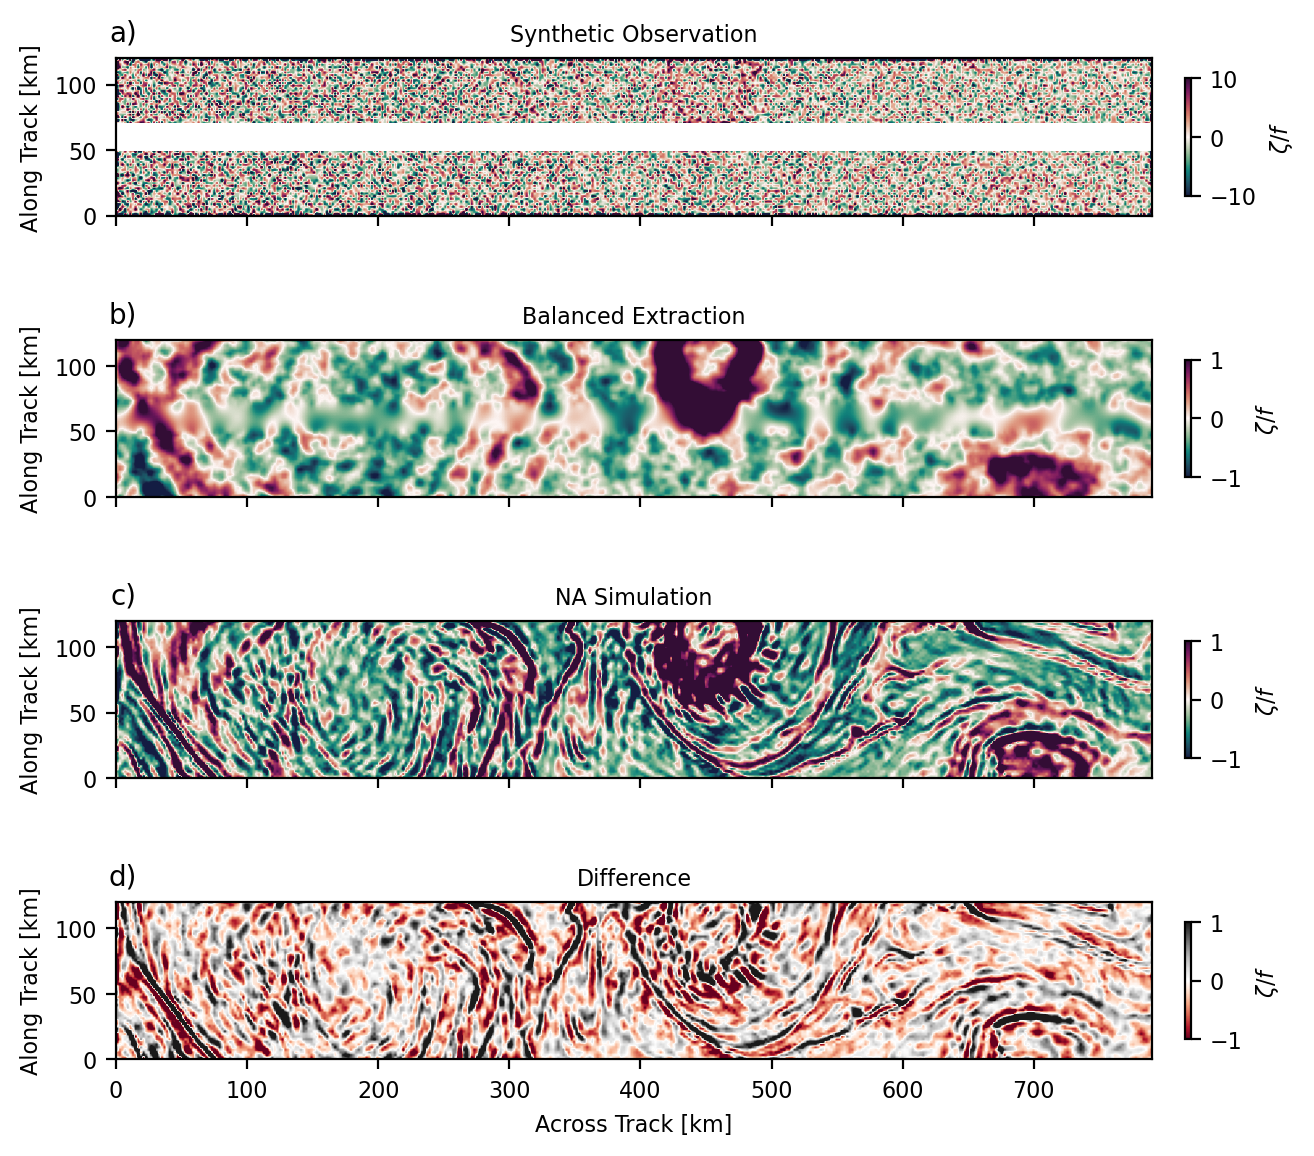

In [13]:
from scipy.ndimage import gaussian_filter  # add once at top
import JWS_SWOT_toolbox as swot
importlib.reload(swot) 

# Compute the geostrophic vorticity 
cmap = cmocean.cm.curl
vmin = -1
vmax = 1

# Reshape SSH fields to 2D
ht_map = ht_all[index, :, :] # put into m 
h_truth = karin_NA.ssha_full[index]
extent = [0, nyt * karin_NA.dy * 1e-3, 0, nxt * karin_NA.dx * 1e-3]

## Vorticity fields
lats = np.linspace(np.nanmin(karin_NA.lat[index]), np.nanmax(karin_NA.lat[index]), nyt)

# Compute geostrophic vorticies 
vort_obs = swot.compute_geostrophic_vorticity(field_filled, karin_NA.dx, karin_NA.dy, lats)
vort_obs[nan_mask] = np.nan
vort_recon = swot.compute_geostrophic_vorticity(ht_map, 2000, 2000, lats)
vort_truth = swot.compute_geostrophic_vorticity(h_truth, 2000, 2000, lats)
#vort_truth = gaussian_filter(vort_truth, sigma=0.5, mode='nearest')  # tiny smooth (σ in grid cells)
vort_truth = vort_truth[:, 4:64]
vort_diff = vort_truth - vort_recon

# Plot
fig, axs = plt.subplots(4, 1, figsize=(7, 7), sharex=True, dpi=200)

# Panel 1: Noisy SWOT with nadir obs
im0 = axs[0].imshow(vort_obs.T, origin='lower', cmap=cmap,
                    aspect='equal', extent=extent, vmin=10*vmin, vmax=10*vmax)
axs[0].set_title('Synthetic Observation', fontsize=fsize)
cbar = fig.colorbar(im0, ax=axs[0], fraction=0.015, pad=0.03, shrink=0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)


# Panel 2: Recovered
im1 = axs[1].imshow(vort_recon.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[1].set_title('Balanced Extraction', fontsize=fsize)
cbar = fig.colorbar(im1, ax=axs[1], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)

# Panel 3: Simulation
im2 = axs[2].imshow(vort_truth.T, origin='lower', cmap=cmap, aspect='equal',
                    extent=extent, vmin=vmin, vmax=vmax)
axs[2].set_title('NA Simulation', fontsize=fsize)
cbar = fig.colorbar(im2, ax=axs[2], fraction=0.015, pad=0.03, shrink = 0.5)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_label(r'$\zeta / f$', size=fsize)

# Panel 4 difference
im3 = axs[3].imshow(vort_diff.T, origin='lower', cmap='RdGy', aspect='equal', 
                    extent=extent , vmin=vmin, vmax=vmax)
axs[3].set_title('Difference', fontsize=fsize)
cbar = fig.colorbar(im3, ax=axs[3], fraction=0.015, pad=0.03, shrink = 0.5)
#cbar.set_label('SSHA [m]', size=8)
cbar.set_label(r'$\zeta / f$', size=fsize)
cbar.ax.tick_params(labelsize=fsize)
cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
cbar.update_ticks()

# Panel 5 posterior variance
# im4 = axs[4].imshow(std_zeta.T, origin='lower', cmap='viridis', aspect='equal', 
#                     extent=extent, vmin = 0.5, vmax = 0.65)
# axs[4].set_title('Posterior Std.', fontsize=fsize)
# cbar = fig.colorbar(im4, ax=axs[4], fraction=0.015, pad=0.03, shrink = 0.5)
# cbar.set_label(r'Std. $\zeta / f$', size=fsize)
# cbar.ax.tick_params(labelsize=fsize)
# cbar.set_ticks(np.linspace(cbar.vmin, cbar.vmax, 3))
# cbar.update_ticks()

for lab, ax in zip(['a)', 'b)', 'c)', 'd)'], axs):
    ax.text(0.02, 1.07, lab, transform=ax.transAxes,
            fontsize=fsize+2, va='bottom', ha='right')

# Axis labels and ticks
axs[3].set_xlabel('Across Track [km]', fontsize=fsize)
for ax in axs:
    ax.set_ylabel('Along Track [km]', fontsize=fsize)
    ax.tick_params(axis='both', labelsize=fsize)
    plt.savefig('vort_extraction.pdf', bbox_inches='tight')
plt.show()

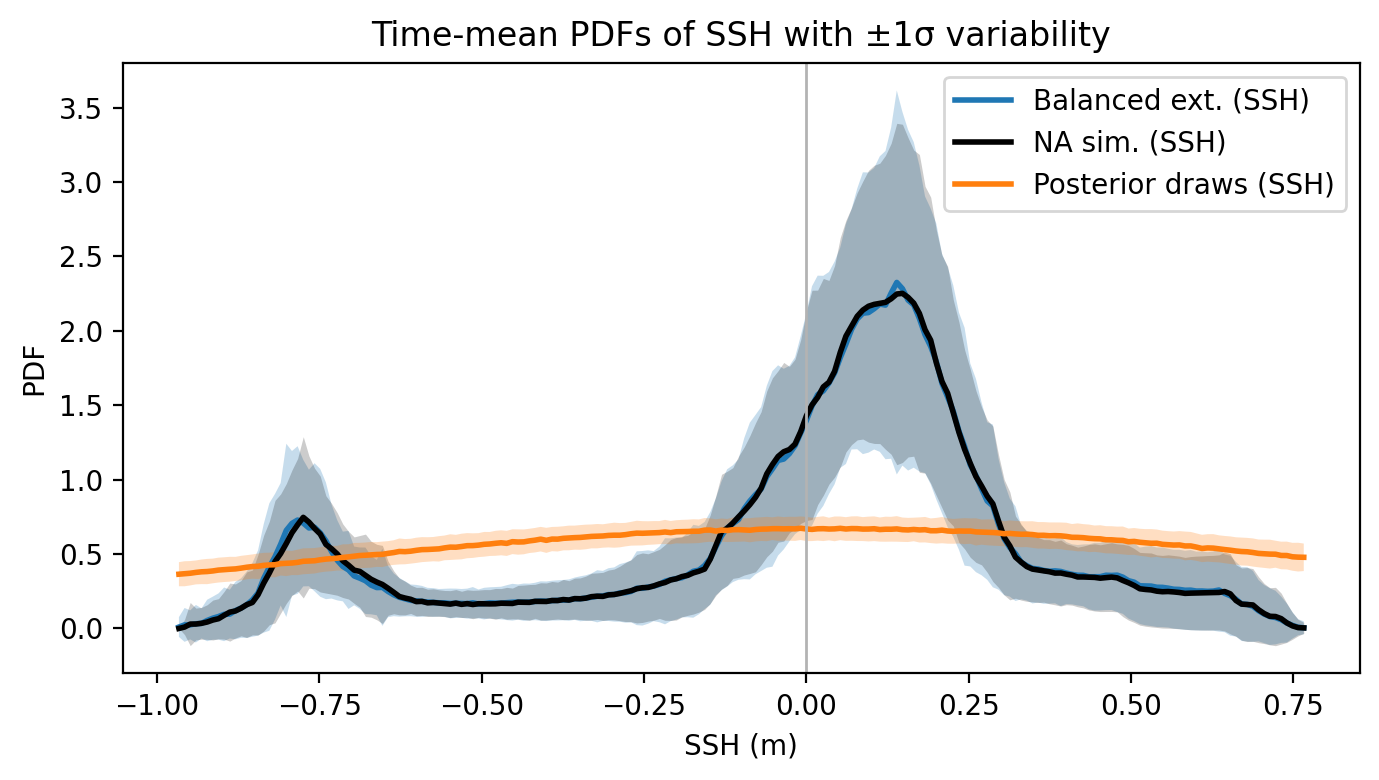

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Basic setup -----
n_times = ht_all.shape[0]
nyt, nxt = ht_all[0].shape
n = nyt * nxt  
nsamp = 10

H_truth, H_recon = [], []

pool_truth, pool_recon = [], []
for i in range(n_times):
    h_rec = np.asarray(ht_all[i]).ravel()
    h_tru = np.asarray(karin_NA.ssha_full[i]).ravel()
    pool_recon.append(h_rec[np.isfinite(h_rec)])
    pool_truth.append(h_tru[np.isfinite(h_tru)])

pool_truth = np.concatenate(pool_truth) if pool_truth else np.array([])
pool_recon = np.concatenate(pool_recon) if pool_recon else np.array([])

lo = np.nanmin([np.nanmin(pool_truth), np.nanmin(pool_recon)])
hi = np.nanmax([np.nanmax(pool_truth), np.nanmax(pool_recon)])
n_bins = 200
edges = np.linspace(lo, hi, n_bins + 1)
centers = 0.5 * (edges[:-1] + edges[1:])

# ----- Second pass: per-time histograms with shared edges -----
for i in range(n_times):
    h_rec = np.asarray(ht_all[i]).ravel()
    h_tru = np.asarray(karin_NA.ssha_full[i]).ravel()
    h_rec = h_rec[np.isfinite(h_rec)]
    h_tru = h_tru[np.isfinite(h_tru)]
    H_recon.append(np.histogram(h_rec, bins=edges, density=True)[0])
    H_truth.append(np.histogram(h_tru, bins=edges, density=True)[0])

H_truth = np.asarray(H_truth)   # (n_times, n_bins)
H_recon = np.asarray(H_recon)   # (n_times, n_bins)

# Time-mean PDFs and ±1σ variability across time
mean_truth = np.nanmean(H_truth, axis=0)
mean_recon = np.nanmean(H_recon, axis=0)
err_truth  = np.nanstd(H_truth, axis=0, ddof=1)
err_recon  = np.nanstd(H_recon, axis=0, ddof=1)

# ----- OPTIONAL: posterior draws over one time index (compact & correct) -----

H_post = []  # collect histograms from ALL draws across ALL times
for i in range(n_times):
    mu = np.asarray(ht_all[i]).ravel()  # posterior mean SSH at time i
    for _ in range(nsamp):
        z = rng.standard_normal(n)
        h_vec = mu + L @ z              # one posterior draw on the grid
        h_vec = h_vec[np.isfinite(h_vec)]
        H_post.append(np.histogram(h_vec, bins=edges, density=True)[0])

H_post = np.asarray(H_post)  # (n_times*nsamp, n_bins)
post_mean_pdf = np.nanmean(H_post, axis=0)
post_err_pdf  = np.nanstd(H_post, axis=0, ddof=1)

# ----- Plot -----
plt.figure(figsize=(7, 4), dpi=200)
lr, = plt.plot(centers, mean_recon, lw=2, label='Balanced ext. (SSH)')
plt.fill_between(centers, mean_recon - err_recon, mean_recon + err_recon,
                 alpha=0.25, linewidth=0)
lt, = plt.plot(centers, mean_truth, lw=2, color='k', label='NA sim. (SSH)')
plt.fill_between(centers, mean_truth - err_truth, mean_truth + err_truth,
                 alpha=0.20, color='k', linewidth=0)
if post_mean_pdf is not None:
    lp, = plt.plot(centers, post_mean_pdf, lw=2, label='Posterior draws (SSH)')
    plt.fill_between(centers, post_mean_pdf - post_err_pdf, post_mean_pdf + post_err_pdf,
                     alpha=0.25, linewidth=0)
plt.axvline(0, color='0.7', lw=1)
plt.xlabel('SSH (m)')
plt.ylabel('PDF')
plt.title('Time-mean PDFs of SSH with ±1σ variability')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('pdf_ssh_time_averaged_simple.pdf', bbox_inches='tight')
plt.show()


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from scipy.ndimage import gaussian_filter

# ---------- helpers ----------
def compute_stats(arr):
    arr = np.asarray(arr)
    arr = arr[np.isfinite(arr)]
    return np.mean(arr), np.std(arr), skew(arr), kurtosis(arr, fisher=True)

# ---------- loop over time using ht_all ----------
n_times = ht_all.shape[0]

centroids_truth, stds_truth, skews_truth, kurts_truth = [], [], [], []
centroids_reco,  stds_reco,  skews_reco,  kurts_reco  = [], [], [], []

pool_truth = []
pool_recon = []

for i in range(n_times):
    # fields (meters)
    ht_map  = ht_all[i]                 # balanced reconstruction
    h_truth = karin_NA.ssha_full[i]     # truth

    # vorticity
    vort_recon = swot.compute_geostrophic_vorticity(ht_map, 2000, 2000, lats)
    vort_truth = swot.compute_geostrophic_vorticity(h_truth, 2000, 2000, lats)

    # small smooth + crop (match your earlier choices)
    #vort_truth = gaussian_filter(vort_truth, sigma=0.5, mode='nearest')
    vort_truth = vort_truth[:, 4:64]

    # flatten & clean
    vals_truth = vort_truth.ravel()
    vals_truth = vals_truth[np.isfinite(vals_truth)]
    vals_recon = vort_recon.ravel()
    vals_recon = vals_recon[np.isfinite(vals_recon)]

    # per-time stats
    m_t, s_t, sk_t, ku_t = compute_stats(vals_truth)
    m_r, s_r, sk_r, ku_r = compute_stats(vals_recon)

    centroids_truth.append(m_t); stds_truth.append(s_t); skews_truth.append(sk_t); kurts_truth.append(ku_t)
    centroids_reco.append(m_r);  stds_reco.append(s_r);  skews_reco.append(sk_r);  kurts_reco.append(ku_r)

    pool_truth.append(vals_truth)
    pool_recon.append(vals_recon)

# ---------- time-averaged (across-index) stats ----------
centroids_truth = np.array(centroids_truth); stds_truth = np.array(stds_truth)
skews_truth     = np.array(skews_truth);     kurts_truth = np.array(kurts_truth)

centroids_reco  = np.array(centroids_reco);  stds_reco  = np.array(stds_reco)
skews_reco      = np.array(skews_reco);      kurts_reco = np.array(kurts_reco)

mean_centroid_truth = centroids_truth.mean();  std_centroid_truth = centroids_truth.std(ddof=1)
mean_std_truth      = stds_truth.mean();       std_std_truth      = stds_truth.std(ddof=1)
mean_skew_truth     = skews_truth.mean();      std_skew_truth     = skews_truth.std(ddof=1)
mean_kurt_truth     = kurts_truth.mean();      std_kurt_truth     = kurts_truth.std(ddof=1)

mean_centroid_reco  = centroids_reco.mean();   std_centroid_reco  = centroids_reco.std(ddof=1)
mean_std_reco       = stds_reco.mean();        std_std_reco       = stds_reco.std(ddof=1)
mean_skew_reco      = skews_reco.mean();       std_skew_reco      = skews_reco.std(ddof=1)
mean_kurt_reco      = kurts_reco.mean();       std_kurt_reco      = kurts_reco.std(ddof=1)

print("\n=== Time-averaged statistics (mean ± std across indices) ===")
print("NA Simulation (truth):")
print(f"  mean = {mean_centroid_truth:.3f} ± {std_centroid_truth:.3f}")
print(f"  std  = {mean_std_truth:.3f} ± {std_std_truth:.3f}")
print(f"  skew = {mean_skew_truth:.3f} ± {std_skew_truth:.3f}")
print(f"  kurt = {mean_kurt_truth:.3f} ± {std_kurt_truth:.3f}")

print("\nBalanced Extraction (recon):")
print(f"  mean = {mean_centroid_reco:.3f} ± {std_centroid_reco:.3f}")
print(f"  std  = {mean_std_reco:.3f} ± {std_std_reco:.3f}")
print(f"  skew = {mean_skew_reco:.3f} ± {std_skew_reco:.3f}")
print(f"  kurt = {mean_kurt_reco:.3f} ± {std_kurt_reco:.3f}")

# ---------- pooled PDFs across time ----------
pool_truth = np.concatenate(pool_truth)
pool_recon = np.concatenate(pool_recon)

n_bins = 200
hist_truth, edges = np.histogram(pool_truth, bins=n_bins, density=True)
centers = 0.5 * (edges[:-1] + edges[1:])
hist_recon, _ = np.histogram(pool_recon, bins=edges, density=True)

# ---------- time-mean PDFs with error bars ----------

# 1) First pass: find global min/max over time (to fix common bin edges)
min_val = np.inf
max_val = -np.inf
for i in range(n_times):
    # recompute per-time arrays (same as earlier loop)
    ht_map  = ht_all[i]
    h_truth = karin_NA.ssha_full[i]

    vort_recon = swot.compute_geostrophic_vorticity(ht_map, 2000, 2000, lats)
    vort_truth = swot.compute_geostrophic_vorticity(h_truth, 2000, 2000, lats)
    vort_truth = gaussian_filter(vort_truth, sigma=0.5, mode='nearest')
    vort_truth = vort_truth[:, 4:64]

    vals_truth = vort_truth.ravel(); vals_truth = vals_truth[np.isfinite(vals_truth)]
    vals_recon = vort_recon.ravel(); vals_recon = vals_recon[np.isfinite(vals_recon)]

    if vals_truth.size:
        min_val = min(min_val, np.nanmin(vals_truth))
        max_val = max(max_val, np.nanmax(vals_truth))
    if vals_recon.size:
        min_val = min(min_val, np.nanmin(vals_recon))
        max_val = max(max_val, np.nanmax(vals_recon))

n_bins = 200
edges = np.linspace(min_val, max_val, n_bins + 1)
centers = 0.5 * (edges[:-1] + edges[1:])

# 2) Second pass: per-time histograms with shared edges
H_truth = []
H_recon = []
for i in range(n_times):
    ht_map  = ht_all[i]
    h_truth = karin_NA.ssha_full[i]

    vort_recon = swot.compute_geostrophic_vorticity(ht_map, 2000, 2000, lats)
    vort_truth = swot.compute_geostrophic_vorticity(h_truth, 2000, 2000, lats)
    vort_truth = vort_truth[:, 4:64]

    vals_truth = vort_truth.ravel(); vals_truth = vals_truth[np.isfinite(vals_truth)]
    vals_recon = vort_recon.ravel(); vals_recon = vals_recon[np.isfinite(vals_recon)]

    h_t, _ = np.histogram(vals_truth, bins=edges, density=True)
    h_r, _ = np.histogram(vals_recon, bins=edges, density=True)
    H_truth.append(h_t)
    H_recon.append(h_r)

H_truth = np.asarray(H_truth)  # shape (n_times, n_bins)
H_recon = np.asarray(H_recon)

# 3) Time-mean and variability
mean_truth = np.nanmean(H_truth, axis=0)
mean_recon = np.nanmean(H_recon, axis=0)

err_truth = np.nanstd(H_truth, axis=0, ddof=1)  # ±1σ across time (variability)
err_recon = np.nanstd(H_recon, axis=0, ddof=1)

# ---- NaN/Inf safety for fill_between ----
err_truth_safe = np.nan_to_num(err_truth, nan=0.0, posinf=0.0, neginf=0.0)
err_recon_safe = np.nan_to_num(err_recon, nan=0.0, posinf=0.0, neginf=0.0)


# 4) --- Now we draw from the posteiorr mean and build up stats 
assert P.shape[0] == nxt * nyt, "P size must equal nxt*nyt"

# Cholesky factor of posterior covariance (tiny jitter for stability)
jitter = 1e-10 * (np.trace(P) / n)
L = np.linalg.cholesky(P + jitter * np.eye(n))

nsamp = 10
rng = np.random.default_rng(42)

vort_samples = []
print("Sampling posterior")
for i in range(n_times):
    mu_post = ht_all[i].flatten() #ht_NA_sim
    for _ in range(nsamp):
        z = rng.standard_normal(n)
        h_vec = mu_post + L @ z                          # sample from N(mu_post, P)
        h_map = h_vec.reshape(nyt, nxt)
    
        h_map = h_map / 100.0
    
        vort = swot.compute_geostrophic_vorticity(h_map, dx_m, dy_m, lats)
        vort = np.asarray(vort)
        vort = vort[np.isfinite(vort)]
        if vort.size:
            vort_samples.append(vort)
    
    if not vort_samples:
        raise RuntimeError("No finite vorticity values from posterior draws.")

# Histograms per draw using the same 'edges' defined earlier
H = np.stack([np.histogram(v, bins=edges, density=True)[0] for v in vort_samples])
post_mean_pdf = np.nanmean(H, axis=0)
post_err_pdf  = np.nanstd(H, axis=0, ddof=1)


# 4) Plot mean PDFs with shaded error bands + TEXT BOX
plt.figure(figsize=(7, 4), dpi=200)

# Balanced first so we can reuse its color for the band
line_recon, = plt.plot(centers, mean_recon, color='b', lw=2, label='Balanced ext.')
recon_color = line_recon.get_color()
plt.fill_between(
    centers,
    mean_recon - err_recon_safe,
    mean_recon + err_recon_safe,
    facecolor=recon_color, alpha=0.25, linewidth=0
)

line_truth, = plt.plot(centers, mean_truth, lw=2, color='k', label='NA sim.')
plt.fill_between(
    centers,
    mean_truth - err_truth_safe,
    mean_truth + err_truth_safe,
    facecolor='k', alpha=0.20, linewidth=0
)

line, = plt.plot(centers, post_mean_pdf, lw=2, color='tab:green', label='Posterior draws')
face = line.get_color()
plt.fill_between(centers, post_mean_pdf - post_err_pdf, post_mean_pdf + post_err_pdf,
                 alpha=0.25, facecolor=face, linewidth=0)

plt.axvline(0, color='grey', linestyle='-', linewidth=1)
plt.xlabel(r'$\zeta / f$'); plt.ylabel('PDF')
plt.title('PDF of Cyclonicity')
plt.legend(loc='upper right', fontsize=9.5)
plt.xlim(-2, 2)

# ---- Put the text string back on (using your time-averaged stats computed above) ----
textstr = (
    "NA Simulation:\n"
    f"  mean = {mean_centroid_truth:.3f} ± {std_centroid_truth:.3f}\n"
    f"  std  = {mean_std_truth:.3f} ± {std_std_truth:.3f}\n"
    f"  skew = {mean_skew_truth:.3f} ± {std_skew_truth:.3f}\n"
    f"  kurt = {mean_kurt_truth:.3f} ± {std_kurt_truth:.3f}\n\n"
    "Balanced Extraction:\n"
    f"  mean = {mean_centroid_reco:.3f} ± {std_centroid_reco:.3f}\n"
    f"  std  = {mean_std_reco:.3f} ± {std_std_reco:.3f}\n"
    f"  skew = {mean_skew_reco:.3f} ± {std_skew_reco:.3f}\n"
    f"  kurt = {mean_kurt_reco:.3f} ± {std_kurt_reco:.3f}"
)
plt.text(
    1.05, 0.99, textstr,
    transform=plt.gca().transAxes,
    va='top', fontsize=9.5,
    bbox=dict(boxstyle='square', facecolor='white', alpha=0.0)
)

# leave space for the text box
plt.subplots_adjust(right=0.65)

plt.savefig('pdf_cyclon_time_averaged.pdf', bbox_inches='tight')
plt.show()


=== Time-averaged statistics (mean ± std across indices) ===
NA Simulation (truth):
  mean = -0.038 ± 0.021
  std  = 0.739 ± 0.107
  skew = 1.171 ± 0.698
  kurt = 7.602 ± 5.867

Balanced Extraction (recon):
  mean = -0.035 ± 0.021
  std  = 0.431 ± 0.090
  skew = 1.273 ± 0.505
  kurt = 3.663 ± 2.129
Sampling posterior


NameError: name 'dx_m' is not defined

In [15]:
from scipy.linalg import solve, cholesky
import scipy.sparse as sp

def laplacian_operator(ny, nx, dx, dy):
    """
    Computes a 2D Laplacian using second-order accurate schemes.
    - Central difference for the interior.
    - Second-order one-sided (forward/backward) differences for the boundaries.
    """
    N = ny * nx
    L = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    # Coefficients for brevity
    cx = 1 / dx**2
    cy = 1 / dy**2

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # X-contribution to the Laplacian
            if i == 0:
                # 2nd-order forward difference for 2nd derivative
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i + 1, j)] += -5 * cx
                L[k, idx(i + 2, j)] +=  4 * cx
                L[k, idx(i + 3, j)] += -1 * cx
            elif i == nx - 1:
                # 2nd-order backward difference for 2nd derivative
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i - 1, j)] += -5 * cx
                L[k, idx(i - 2, j)] +=  4 * cx
                L[k, idx(i - 3, j)] += -1 * cx
            else:
                # 2nd-order central difference for 2nd derivative
                L[k, idx(i - 1, j)] +=  1 * cx
                L[k, idx(i, j)]     += -2 * cx
                L[k, idx(i + 1, j)] +=  1 * cx

            # Y-contribution to the Laplacian
            if j == 0:
                # 2nd-order forward difference
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j + 1)] += -5 * cy
                L[k, idx(i, j + 2)] +=  4 * cy
                L[k, idx(i, j + 3)] += -1 * cy
            elif j == ny - 1:
                # 2nd-order backward difference
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j - 1)] += -5 * cy
                L[k, idx(i, j - 2)] +=  4 * cy
                L[k, idx(i, j - 3)] += -1 * cy
            else:
                # 2nd-order central difference
                L[k, idx(i, j - 1)] +=  1 * cy
                L[k, idx(i, j)]     += -2 * cy
                L[k, idx(i, j + 1)] +=  1 * cy

    return L.tocsr()
    
def gradient_operator(ny, nx, dx, dy):
    """
    Computes gradient operators Gx and Gy using second-order accurate schemes.
    - Central difference for the interior.
    - Second-order one-sided (forward/backward) differences for the boundaries.
    """
    N = ny * nx
    Gx = sp.lil_matrix((N, N))
    Gy = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # Gx operator (derivative with respect to x)
            if i == 0:
                # 2nd-order forward difference at the left edge
                Gx[k, idx(i, j)]     = -1.5 / dx
                Gx[k, idx(i + 1, j)] =  2.0 / dx
                Gx[k, idx(i + 2, j)] = -0.5 / dx
            elif i == nx - 1:
                # 2nd-order backward difference at the right edge
                Gx[k, idx(i, j)]     =  1.5 / dx
                Gx[k, idx(i - 1, j)] = -2.0 / dx
                Gx[k, idx(i - 2, j)] =  0.5 / dx
            else:
                # 2nd-order central difference for the interior
                Gx[k, idx(i - 1, j)] = -0.5 / dx
                Gx[k, idx(i + 1, j)] =  0.5 / dx

            # Gy operator (derivative with respect to y)
            if j == 0:
                # 2nd-order forward difference at the bottom edge
                Gy[k, idx(i, j)]     = -1.5 / dy
                Gy[k, idx(i, j + 1)] =  2.0 / dy
                Gy[k, idx(i, j + 2)] = -0.5 / dy
            elif j == ny - 1:
                # 2nd-order backward difference at the top edge
                Gy[k, idx(i, j)]     =  1.5 / dy
                Gy[k, idx(i, j - 1)] = -2.0 / dy
                Gy[k, idx(i, j - 2)] =  0.5 / dy
            else:
                # 2nd-order central difference for the interior
                Gy[k, idx(i, j - 1)] = -0.5 / dy
                Gy[k, idx(i, j + 1)] =  0.5 / dy

    return Gx.tocsr(), Gy.tocsr()

# Physical constants
g = 9.81
omega = 7.2921e-5
eps_f = 1e-12

# Coriolis parameter
# mean latitude scalar (simple)
mean_lat_deg = float(np.nanmean(karin.lat[index,:,:]))
lat_rad = np.deg2rad(mean_lat_deg)
f = 2.0 * omega * np.sin(lat_rad)
if abs(f) < eps_f:
    f = np.sign(f) * eps_f if f != 0 else eps_f

# Build linear operators
Gx, Gy = gradient_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)
Lap = laplacian_operator(nyt, nxt, dx=karin.dx_km, dy=karin.dy_km)

# Cholesky decomposition of posterior covariance matrix: P = Lp @ Lp.T
Lp = cholesky(P, lower=True)
print("Cholesky done.")

# Scale factors for physical units
scale_grad = 1e-3   # km to m conversion
scale_lap = 1e-6    # km^2 to m^2 conversion

# Operators for geostrophic quantities
Uop = (-(g / f) * scale_grad) * Gy
Vop = ((g / f) * scale_grad) * Gx
Zop = ((g / (f**2)) * scale_lap) * Lap

# Apply operators to Cholesky factor
Lp_arr = np.asarray(Lp)
ULp = Uop.dot(Lp_arr)
VLp = Vop.dot(Lp_arr)
ZLp = Zop.dot(Lp_arr)

# Compute variances
var_u = np.sum(np.asarray(ULp)**2, axis=1).reshape(nyt, nxt)
var_v = np.sum(np.asarray(VLp)**2, axis=1).reshape(nyt, nxt)
var_zeta = np.sum(np.asarray(ZLp)**2, axis=1).reshape(nyt, nxt)
var_speed = var_u + var_v

# Compute standard deviations
std_u = np.sqrt(var_u)
std_v = np.sqrt(var_v)
std_speed = np.sqrt(var_speed)
std_zeta = np.sqrt(var_zeta)

print("Posterior gradient and Laplacian variances computed.")

Cholesky done.
Posterior gradient and Laplacian variances computed.


In [23]:
# Across-track coordinate in km
x_km = np.arange(nxt) * karin_NA.dx * 1e-3

# --- 1. SSH ---
ssh_diff_std = np.nanstd(h_truth_map - ht_map, axis=0)
ssh_posterior_std = np.mean(np.sqrt(posterior_variance_field[:, :]), axis=0)

# --- 2. Gradient magnitude ---
grad_diff_std = np.nanstd(g_truth - g_recon, axis=0)
grad_posterior_std = np.mean(std_u, axis=0)
grad_posterior_std_v = np.mean(std_v, axis=0)

u_diff_std = np.nanstd(u_truth - u_recon, axis=0)  # [m/s]
v_diff_std = np.nanstd(v_truth - v_recon, axis=0)  # [m/s]

# --- 3. Vorticity ---
vort_diff_std = np.nanstd(vort_truth - vort_recon, axis=0)
vort_posterior_std = np.mean(std_zeta, axis=0)


fig, axs = plt.subplots(3, 1, figsize=(5, 10.5), dpi=150, sharex=True, sharey=False)

# Increase vertical spacing manually
fig.subplots_adjust(hspace=0.4)

# Panel 1: SSH
axs[0].plot(x_km, ssh_diff_std*100, label=r'$\Delta$SSHA Std.', linewidth=1.5)
axs[0].plot(x_km, ssh_posterior_std, '--', label='SSHA Posterior Std.', linewidth=1.5)
axs[0].set_title('SSHA')
axs[0].set_ylabel('Std. [cm]')
axs[0].set_ylim(0.3, 1)
axs[0].legend(fontsize=10)

# Panel 2: Gradient magnitude
axs[1].plot(x_km, grad_diff_std*100 , label=r'$\Delta|{\bf u}_g|$ Std.', linewidth=1.5)
axs[1].plot(x_km, grad_posterior_std, '--', label=r'$u_g$ Posterior Std.', linewidth=1.5)
#axs[1].plot(x_km, grad_posterior_std_v, '--', label=r'$v_g$ Posterior Std.', linewidth=1.5)
axs[1].set_title('Geostrophic Speed')
axs[1].set_ylabel(r'Std. [ms$^{-1}$] ')
#axs[1].set_ylim(0.05, 0.12)
axs[1].legend(fontsize=10)

# Panel 4: Vorticity
axs[2].plot(x_km, vort_diff_std, label=r'$\Delta \zeta$ Std.', linewidth=1.5)
axs[2].plot(x_km[1:-1], vort_posterior_std[1:-1]/100, '--', label=r'$\zeta$ Posterior Std.', linewidth=1.5)
axs[2].set_title('Geostrophic Vorticity')
axs[2].set_xlabel('Across Track [km]')
axs[2].set_ylabel(r'Std. [$1/f \,$]')
#axs[2].set_ylim(0.4, 0.75)
axs[2].legend(fontsize=10)
plt.savefig('cross_track_std.pdf', bbox_inches='tight')
plt.show()


NameError: name 'u_truth' is not defined

NameError: name 'u_diff_std' is not defined

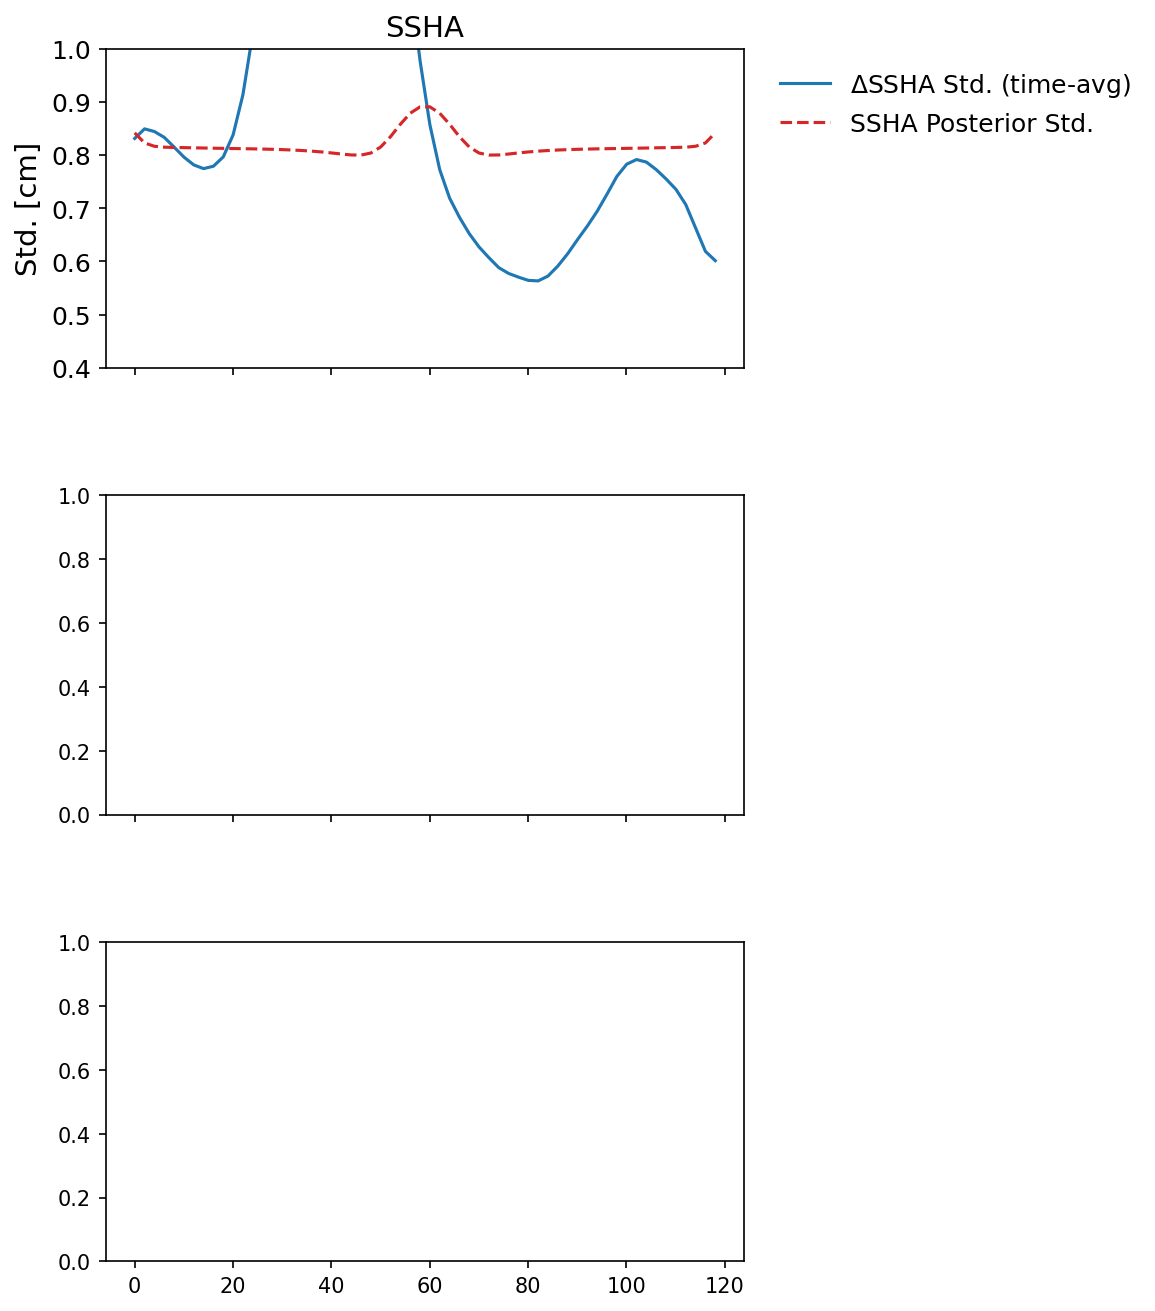

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# --- Font size controls ---
label_fontsize = 14
tick_fontsize  = 12
legend_fontsize = 12

# --- plot (convert to desired display units) ---
fig, axs = plt.subplots(3, 1, figsize=(6.5, 10.5), dpi=150, sharex=True)
fig.subplots_adjust(hspace=0.4, right=0.78)  # room for legends on the right

# Panel 1: SSH (m -> cm)
axs[0].plot(x_km, ssh_diff_std*100, label=r'$\Delta$SSHA Std. (time-avg)', lw=1.5)
axs[0].plot(x_km, ssh_posterior_std, '--', label='SSHA Posterior Std.', color='tab:red', lw=1.5)
axs[0].set_title('SSHA', fontsize=label_fontsize)
axs[0].set_ylabel('Std. [cm]', fontsize=label_fontsize)
axs[0].set_ylim(0.4, 1.0)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)
axs[0].legend(
    fontsize=legend_fontsize, loc='upper left',
    bbox_to_anchor=(1.02, 1.0), frameon=False
)

# Panel 2: Geostrophic speed (m/s -> cm/s)
axs[1].plot(x_km, u_diff_std * 100, label=r'$\Delta{u}_g$ Std. (time-avg)', lw=1.5)
axs[1].plot(x_km, v_diff_std * 100, label=r'$\Delta{v}_g$ Std. (time-avg)', lw=1.5)
axs[1].plot(x_km, grad_posterior_std, '--', label=r'$u_g$ Posterior Std.',  color='tab:red', lw=1.5)
axs[1].plot(x_km, grad_posterior_std_v, '--', label=r'$v_g$ Posterior Std.', color='tab:green', lw=1.5)
axs[1].set_title('Geostrophic Speed', fontsize=label_fontsize)
axs[1].set_ylabel(r'Std. [cm s$^{-1}$]', fontsize=label_fontsize)
axs[1].set_ylim(6.0, 12)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)
axs[1].legend(
    fontsize=legend_fontsize, loc='upper left',
    bbox_to_anchor=(1.02, 1.0), frameon=False
)

# Panel 3: Vorticity (unitless ζ/f)
axs[2].plot(x_km[1:-1], vort_diff_std[1:-1], label=r'$\Delta \zeta$ Std. (time-avg)', lw=1.5)
axs[2].plot(x_km[1:-1], vort_posterior_std[1:-1]/100, '--', label=r'$\zeta$ Posterior Std.', color='tab:red', lw=1.5)
axs[2].set_title('Geostrophic Vorticity', fontsize=label_fontsize)
axs[2].set_xlabel('Across Track [km]', fontsize=label_fontsize)
axs[2].set_ylabel(r'Std. [$1/f$]', fontsize=label_fontsize)
axs[2].set_ylim(0.4, 0.7)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)
axs[2].legend(
    fontsize=legend_fontsize, loc='upper left',
    bbox_to_anchor=(1.02, 1.0), frameon=False
)

plt.savefig('cross_track_std_timeavg.pdf', bbox_inches='tight')
plt.show()


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.linalg import cholesky
INDEX = 40 
# -----------------------------
# High-accuracy finite-difference operators
# -----------------------------
xt_km = (karin.x_grid[0, :] * 1e-3).ravel()   # convert m → km
def laplacian_operator(ny, nx, dx, dy):
    """
    2D Laplacian with 2nd-order *one-sided* boundary stencils and
    2nd-order central interior.
    dx, dy are in km here; operator gives 1/km^2.
    """
    N = ny * nx
    L = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    cx = 1.0 / (dx**2)
    cy = 1.0 / (dy**2)

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # X contribution
            if i == 0:
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i + 1, j)] += -5 * cx
                L[k, idx(i + 2, j)] +=  4 * cx
                L[k, idx(i + 3, j)] += -1 * cx
            elif i == nx - 1:
                L[k, idx(i, j)]     +=  2 * cx
                L[k, idx(i - 1, j)] += -5 * cx
                L[k, idx(i - 2, j)] +=  4 * cx
                L[k, idx(i - 3, j)] += -1 * cx
            else:
                L[k, idx(i - 1, j)] +=  1 * cx
                L[k, idx(i, j)]     += -2 * cx
                L[k, idx(i + 1, j)] +=  1 * cx

            # Y contribution
            if j == 0:
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j + 1)] += -5 * cy
                L[k, idx(i, j + 2)] +=  4 * cy
                L[k, idx(i, j + 3)] += -1 * cy
            elif j == ny - 1:
                L[k, idx(i, j)]     +=  2 * cy
                L[k, idx(i, j - 1)] += -5 * cy
                L[k, idx(i, j - 2)] +=  4 * cy
                L[k, idx(i, j - 3)] += -1 * cy
            else:
                L[k, idx(i, j - 1)] +=  1 * cy
                L[k, idx(i, j)]     += -2 * cy
                L[k, idx(i, j + 1)] +=  1 * cy

    return L.tocsr()

def gradient_operator(ny, nx, dx, dy):
    """
    Gradient operators (Gx, Gy) with 2nd-order one-sided boundaries and
    2nd-order central interior.
    dx, dy are in km here; operators give 1/km.
    """
    N = ny * nx
    Gx = sp.lil_matrix((N, N))
    Gy = sp.lil_matrix((N, N))

    def idx(i, j):
        return j * nx + i

    for j in range(ny):
        for i in range(nx):
            k = idx(i, j)

            # d/dx
            if i == 0:
                Gx[k, idx(i, j)]     = -1.5 / dx
                Gx[k, idx(i + 1, j)] =  2.0 / dx
                Gx[k, idx(i + 2, j)] = -0.5 / dx
            elif i == nx - 1:
                Gx[k, idx(i, j)]     =  1.5 / dx
                Gx[k, idx(i - 1, j)] = -2.0 / dx
                Gx[k, idx(i - 2, j)] =  0.5 / dx
            else:
                Gx[k, idx(i - 1, j)] = -0.5 / dx
                Gx[k, idx(i + 1, j)] =  0.5 / dx

            # d/dy
            if j == 0:
                Gy[k, idx(i, j)]     = -1.5 / dy
                Gy[k, idx(i, j + 1)] =  2.0 / dy
                Gy[k, idx(i, j + 2)] = -0.5 / dy
            elif j == ny - 1:
                Gy[k, idx(i, j)]     =  1.5 / dy
                Gy[k, idx(i, j - 1)] = -2.0 / dy
                Gy[k, idx(i, j - 2)] =  0.5 / dy
            else:
                Gy[k, idx(i, j - 1)] = -0.5 / dy
                Gy[k, idx(i, j + 1)] =  0.5 / dy

    return Gx.tocsr(), Gy.tocsr()

# -----------------------------
# Physical constants and Coriolis
# -----------------------------
g = 9.81
omega = 7.2921e-5
eps_f = 1e-12

mean_lat_deg = float(np.nanmean(karin.lat[INDEX, :, :]))
f = 2.0 * omega * np.sin(np.deg2rad(mean_lat_deg))
if abs(f) < eps_f:
    f = np.sign(f) * eps_f if f != 0 else eps_f

# -----------------------------
# Build linear operators on target grid
# -----------------------------
dx_km = float(karin.dx_km)
dy_km = float(karin.dy_km)

Gx, Gy = gradient_operator(nyt, nxt, dx_km, dy_km)
Lap    = laplacian_operator(nyt, nxt, dx_km, dy_km)

# Convert km-based operators to SI (per meter and per meter^2)
scale_grad = 1e-3  # 1/km -> 1/m
scale_lap  = 1e-6  # 1/km^2 -> 1/m^2

# u_g, v_g, and zeta/f operators acting on SSH (meters)
Uop = (-(g / f) * scale_grad) * Gy   # gives u_g [m/s] when applied to h [m]
Vop = ( (g / f) * scale_grad) * Gx   # gives v_g [m/s]
Zop = ( (g / (f**2)) * scale_lap) * Lap  # gives (zeta/f) [dimensionless]

# -----------------------------
# Robust Cholesky of P
# -----------------------------
Ntot = P.shape[0]
try:
    Lp = cholesky(P, lower=True, overwrite_a=False, check_finite=False)
except np.linalg.LinAlgError:
    Lp = cholesky(P + 1e-12 * np.eye(Ntot), lower=True, overwrite_a=False, check_finite=False)

Lp_arr = np.asarray(Lp)

# Propagate P via A Lp (diag(A P A^T) = sum_k (A Lp)_{:,k}^2)
ULp = Uop.dot(Lp_arr)
VLp = Vop.dot(Lp_arr)
ZLp = Zop.dot(Lp_arr)

var_u    = np.sum(np.asarray(ULp)**2, axis=1).reshape(nyt, nxt)   # [m^2/s^2]
var_v    = np.sum(np.asarray(VLp)**2, axis=1).reshape(nyt, nxt)   # [m^2/s^2]
var_zeta = np.sum(np.asarray(ZLp)**2, axis=1).reshape(nyt, nxt)   # [dimensionless^2]
var_spd  = var_u + var_v

std_u     = np.sqrt(var_u)               # [m/s]
std_v     = np.sqrt(var_v)               # [m/s]
std_speed = np.sqrt(var_spd)             # [m/s]
std_zeta  = np.sqrt(var_zeta)            # [dimensionless]
std_h     = np.sqrt(posterior_variance_field)  # [m]

# -----------------------------
# 1D across-track profiles (take mean over y)
# -----------------------------
X = xt_km.reshape(nyt, nxt)
x_km = X[0, :]  # across-track coordinate (km)

ssh_posterior_std_cm = np.mean(std_h, axis=0) * 100.0            # [cm]
u_posterior_std_cms  = np.mean(std_u, axis=0) * 100.0            # [cm/s]
v_posterior_std_cms  = np.mean(std_v, axis=0) * 100.0            # [cm/s]
zeta_over_f_std      = np.mean(std_zeta, axis=0)                 # [dimensionless]

# -----------------------------
# Plot
# -----------------------------
fig, axs = plt.subplots(3, 1, figsize=(5.2, 10.5), dpi=150, sharex=True)
fig.subplots_adjust(hspace=0.45)

# 1) SSH std (posterior)
axs[0].plot(x_km, ssh_posterior_std_cm, lw=1.6, label='Posterior Std.')
axs[0].set_title('SSHA Posterior Std.')
axs[0].set_ylabel('Std. [cm]')
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=9)

# 2) Geostrophic speed components std
axs[1].plot(x_km, u_posterior_std_cms, lw=1.6, label=r'$u_g$ Posterior Std.')
axs[1].plot(x_km, v_posterior_std_cms, lw=1.6, ls='--', label=r'$v_g$ Posterior Std.')
axs[1].set_title('Geostrophic Velocities Posterior Std.')
axs[1].set_ylabel(r'Std. [cm s$^{-1}$]')
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=9)

# 3) Geostrophic vorticity ratio std (dimensionless)
axs[2].plot(x_km, zeta_over_f_std, lw=1.6, label=r'$(\zeta/f)$ Posterior Std.')
axs[2].set_title(r'Geostrophic Vorticity $(\zeta/f)$ Posterior Std.')
axs[2].set_xlabel('Across Track [km]')
axs[2].set_ylabel('Std. [—]')
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=9)

plt.savefig('cross_track_posterior_std_fixed.pdf', bbox_inches='tight')
plt.show()
print("Saved: cross_track_posterior_std_fixed.pdf")


ValueError: cannot reshape array of size 60 into shape (395,60)

In [34]:
def stats(name, arr):
    print(f"{name:30s} min={np.nanmin(arr):8.3f}, max={np.nanmax(arr):8.3f}, mean={np.nanmean(arr):8.3f}")

# SSH
stats("ΔSSHA Std [cm]", ssh_diff_std * 100)
stats("Posterior SSHA Std [cm]", ssh_posterior_std)

# Geostrophic velocities (cm/s)
stats("Δu_g Std [cm/s]", u_diff_std * 100)
stats("Δv_g Std [cm/s]", v_diff_std * 100)
stats("Posterior u_g Std [cm/s]", grad_posterior_std)
stats("Posterior v_g Std [cm/s]", grad_posterior_std_v)

# Vorticity (ζ/f)
stats("Δζ Std [1/f]", vort_diff_std)
stats("Posterior ζ Std [1/f]", vort_posterior_std / 100)

ΔSSHA Std [cm]                 min=   0.538, max=   0.826, mean=   0.677
Posterior SSHA Std [cm]        min=   0.619, max=   0.742, mean=   0.637
Δu_g Std [cm/s]                min=   7.873, max=   9.195, mean=   8.168
Δv_g Std [cm/s]                min=   7.022, max=  10.622, mean=   7.819
Posterior u_g Std [cm/s]       min=   7.583, max=   9.219, mean=   7.806
Posterior v_g Std [cm/s]       min=   7.544, max=  11.430, mean=   8.012
Δζ Std [1/f]                   min=   0.567, max=   1.036, mean=   0.604
Posterior ζ Std [1/f]          min=   0.484, max=   0.677, mean=   0.498
